In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, '../src')

In [3]:
import math
from collections import OrderedDict as odict

import torch
import torch.nn as nn
from model import Generator, Discriminator
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from data_utils import ImageFilelistMultiscale, show_batch
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [5]:
dataset = ImageFilelistMultiscale('/home/samenabar/datasets/CLEVR_v1.0/images/train/', '*.png', resolutions=((64,64),))
# subset = torch.utils.data.Subset(dataset, list(range(1024)))

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=False,
)
batch64, = next(iter(loader))

In [6]:
# loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=16,
#     shuffle=False,
#     pin_memory=False,
# )
# batch64, = next(iter(loader))
# subdataset = torch.utils.data.TensorDataset(batch64.to(device))
# sub_loader = torch.utils.data.DataLoader(
#     subdataset,
#     batch_size=2,
#     shuffle=False,
#     pin_memory=False,
# )
# sub_batch64, = next(iter(sub_loader))

In [7]:
# sub_batch64.size()

In [8]:
# def generator_loss(generated, style_fake=None):
#     total_g_loss = torch.nn.functional.binary_cross_entropy_with_logits(generated, torch.ones_like(generated), reduction='none')
#     if style_fake:
#         total_g_loss = total_g_loss + style_loss(style_fake, "ones")

#     return total_g_loss

def calc_different_loss(prediction):
    return torch.nn.functional.binary_cross_entropy_with_logits(prediction, torch.zeros_like(prediction), reduction='none')

def calc_same_loss(prediction):
    return torch.nn.functional.binary_cross_entropy_with_logits(prediction, torch.ones_like(prediction), reduction='none')

In [9]:
class GenWrapper(nn.Module):
    def __init__(self, num_objs=10, z_bg_dim=32, z_fg_dim=64, iters=4, lr=1e-1):
        super().__init__()
        self.bg_emb = nn.Parameter(torch.empty(1, z_bg_dim).normal_(0, 0.2))
        self.fg_emb = nn.Parameter(torch.empty(1, num_objs, z_fg_dim).normal_(0, 0.2))
        self.az_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.2))
        self.tx_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.2))
        self.tz_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.2))
        self.scale_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.2))
        
        self.az_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.tx_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.tz_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.scale_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.pres_proj = nn.Sequential(nn.Linear(z_fg_dim, 32), nn.LeakyReLU(0.2), nn.Linear(32, 1))
        _11 = torch.tensor((-1.0, 1.0))
        self.register_buffer('_11', _11)
        _051 = torch.tensor((0.5, 1.0))
        self.register_buffer('_051', _051)
        _pipi = torch.tensor((-math.pi / 4, math.pi / 4))
        self.register_buffer('_pipi', _pipi)
        
        self.apply(self.init_weights)
        
        self.pres_proj[2].weight.data.zero_()
        self.pres_proj[2].bias.data.fill_(1)
        self.generator = Generator(z_dim_bg=z_bg_dim, z_dim_fg=z_fg_dim)
        
        self.lr = lr
        self.iters = iters
        self.mse_loss = nn.MSELoss(reduction='none')
        
    @staticmethod
    def requires_grad(m):
        for param in m.parameters():
            m.requires_grad = False
        
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Parameter):
            m.data.normal_(0, 0.2)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.2)
            m.bias.data.zero_()
            
    def zero_grad_embs(self):
        self.bg_emb.grad.zero()
        self.fg_emb.grad.zero()
        self.az_emb.grad.zero()
        self.tx_emb.grad.zero()
        self.tz_emb.grad.zero()
        self.scale_emb.grad.zero()
          
    def proj_embeddings(self, embeddings, beta=1.0):
        if 'z_bg' in embeddings:
            z_bg = embeddings['z_bg']
        else:
            z_bg = None
        pres = torch.sigmoid(beta * self.pres_proj(embeddings['z_fg']))
        z_fg = embeddings['z_fg'] * pres
        az = (self.az_proj(embeddings['z_az']).softmax(-1) * self._pipi).sum(-1, keepdim=True) * pres
        scale = (self.scale_proj(embeddings['z_scale']).softmax(-1) * self._051).sum(-1, keepdim=True) * pres
        tx = (self.tx_proj(embeddings['z_tx']).softmax(-1) * self._11).sum(-1, keepdim=True) * pres
        tz = (self.tz_proj(embeddings['z_tz']).softmax(-1) * self._11).sum(-1, keepdim=True) * pres
        scale = scale.clamp(1e-3)
        elev = tilt = ty = torch.zeros_like(az)
        view_in_fg = torch.cat([az, elev, tilt, scale, scale, scale, tx, ty, tz], -1)
        return {
            'z_bg': z_bg,
            'pres': pres,
            'az': az,
            'scale': scale,
            'tx': tx,
            'tz': tz,
            'scale': scale,
            'elev': elev,
            'tilt': tilt,
            'ty': ty,
            'view_in_fg': view_in_fg,
        }
    
    def get_initial_embs(self, bsz):
        return odict([
            ('z_bg', self.bg_emb.expand(bsz, -1).detach().requires_grad_(True)),
            ('z_fg', self.fg_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_az', self.az_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_tx', self.tx_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_tz', self.tz_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_scale', self.scale_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
        ])
    
    def forward(self, inp, disc, beta=1.0, iters=None):
        if iters is None:
            iters = self.iters
        bsz = inp.size(0)

        grad_norms = []
        recon_losses = []
        emb_recon_loss_triplets = []
        gen_debugs = []
        current_embs = self.get_initial_embs(bsz)
        prev_disc_training = disc.training
        disc.train(False)

        with torch.enable_grad():
            for i in range(iters - 1):
                projs = self.proj_embeddings(current_embs)
                
                recon = self.generator(projs['z_bg'], projs['z_fg'], view_in_fg=projs['view_in_fg'])
                with torch.no_grad():
                    recon_loss = self.mse_loss(recon.detach(), inp).flatten(1).sum().mean() # to see progress only
                recon_losses.append(recon_loss)
                # we want the discriminator to say these are the same images and real images
                adv_loss, gen_debug = calc_generator_loss(inp, recon, disc)
                gen_debugs.append(gen_debug)
                
                all_grads = torch.autograd.grad(
                    inputs=current_embs.values(),
                    outputs=adv_loss,
                    only_inputs=True,
                    create_graph=True,
                )

                if self.training:
                    emb_recon_loss_triplets.append(
                        (odict([(k, emb) for k, emb in current_embs.items()]), recon.detach_(), adv_loss.detach_())
                    )
                else:
                    emb_recon_loss_triplets.append(
                        (odict([(k, emb) for k, emb in current_embs.items()]), recon.detach_(), adv_loss.detach_())
                    )
                grad_norms.append(odict([(k, g.norm()) for g, k in zip(all_grads, current_embs.keys())]))

                for grad, k in zip(all_grads, current_embs.keys()):
                    current_embs[k] = (current_embs[k] - self.lr * grad).detach().requires_grad_(True)

            projs = self.proj_embeddings(current_embs)
            recon = self.generator(z_bg, z_fg, view_in_fg=view_in_fg)
            with torch.no_grad():
                recon_loss = self.mse_loss(recon.detach(), inp).flatten(1).sum().mean()
            recon_losses.append(recon_loss)
            # we want the discriminator to say these are the same images and real images
            adv_loss, gen_debug = calc_generator_loss(inp, recon, disc) 
            gen_debugs.append(gen_debug)
            all_grads = torch.autograd.grad(
                inputs=current_embs.values(),
                outputs=adv_loss,
                only_inputs=True,
                create_graph=True,
            )

            if self.training:
                emb_recon_loss_triplets.append(
                    (odict([(k, emb) for k, emb in current_embs.items()]), recon, adv_loss)
                )
            else:
                emb_recon_loss_triplets.append(
                    (odict([(k, emb) for k, emb in current_embs.items()]), recon.detach_(), adv_loss.detach_())
                )
            grad_norms.append(odict([(k, g.norm()) for g, k in zip(all_grads, current_embs.keys())]))
        disc.train(prev_disc_training)
        
        return emb_recon_loss_triplets, grad_norms, recon_losses, gen_debugs

In [10]:
def calc_generator_loss(inp, recon, disc):
    bce_l = nn.BCEWithLogitsLoss(reduction='none')
    # shuffle real and fake images position to avoid overfitting
    bsz = inp.size(0)
    real_first = torch.rand(bsz, 1, 1, 1, device=inp.device) >= 0.5
    adv_contrast_inp = torch.cat((inp * real_first + recon * (~real_first), inp * ~real_first + recon * (real_first)), 1)
    contrast_pred = disc(adv_contrast_inp)
    real_first = real_first.view(bsz)
    # generator tries to make the discriminator say the real and fake images are the same
    are_same_loss = bce_l(contrast_pred[:, 0], torch.ones_like(real_first.float()))
    # try to make discrminator fake images are real
    are_real1 = contrast_pred[~real_first.squeeze(), 1]
    are_real1_loss = bce_l(are_real1, torch.ones_like(are_real1)).sum()
    are_real2 = contrast_pred[real_first.squeeze(), 2]
    are_real2_loss = bce_l(are_real2, torch.ones_like(are_real2)).sum()

    loss = (are_same_loss.sum() + are_real1_loss + are_real2_loss) / bsz
    return loss, {
        'adv_contrast_inp': adv_contrast_inp.detach(),
        'contrast_pred': contrast_pred.detach(),
        'real_first': real_first,
        'are_same_loss': are_same_loss.detach(),
        'are_real_loss': are_real1_loss + are_real2_loss,
    }

In [27]:
def discriminator_update_step(inp, disc, gen):
    bsz = inp.size(0)
    ## DISCRIMINATOR STEP
    emb_recon_loss_triplets, grad_norms, _, _ = gen(inp, disc)

    # Different loss
    # Generate random permutation with all indices different
    indices = torch.arange(bsz)
    perm = torch.randperm(bsz)
    while (indices == perm).any():
        perm = torch.randperm(bsz)
    different_inp = torch.cat([inp, inp[perm]], 1)
    different_pred = disc(different_inp)
    different_loss = calc_different_loss(different_pred[:, 0]).mean()

    # Same loss
    same_inp = inp.repeat(1, 2, 1, 1)
    gate = torch.rand(bsz, 2, 1, 1, device=device) < 0.3 # add noise to reduce overfitting to 30% of images
    gate = gate.repeat_interleave(3, 1)
    same_inp = (same_inp + torch.empty_like(same_inp).normal_(0, 0.02) * gate).clamp(0, 1)
    same_pred = disc(same_inp)
    same_loss = calc_same_loss(same_pred[:, 0])

    mult = 1
    total_contrastive_loss = 0.
    adv_contrast_inputs = []
    adv_contrast_preds = []
    contrastive_losses = []
    
    for (_, recon, _) in emb_recon_loss_triplets[::-1]:
        real_first = torch.rand(bsz, 1, 1, 1, device=device) >= 0.5
        adv_contrast_inp = torch.cat((inp * real_first + recon.detach() * (~real_first), inp * ~real_first + recon.detach() * (real_first)), 1)
        adv_contrast_inputs.append(adv_contrast_inp.detach())
        contrast_pred = disc(adv_contrast_inp)
        adv_contrast_preds.append(contrast_pred.detach())
        real_first = real_first.view(bsz, 1)
        # Target zero for first position: they are different
        # Target 1 for real images and 0 for fake images
        targ = torch.cat((torch.zeros_like(real_first), real_first, ~real_first), -1)
        contrastive_loss_i = nn.functional.binary_cross_entropy_with_logits(contrast_pred, targ.float())
        contrastive_losses.append(contrastive_loss_i.detach())
        total_contrastive_loss = total_contrastive_loss + mult * contrastive_loss_i.sum(-1).mean()
        mult = mult / 2

    total_disc_loss = different_loss.mean() + same_loss.mean() + total_contrastive_loss
    return total_disc_loss, {
        'different_inp': different_inp,
        'different_pred': different_pred.detach(),
        'different_loss': different_loss.detach(),
        'same_inp': same_inp,
        'same_pred': same_pred.detach(),
        'same_loss': same_loss.detach(),
        'adv_contrast_inputs': adv_contrast_inputs,
        'adv_contrast_preds': adv_contrast_preds,
        'contrastive_losses': contrastive_losses,
    }

def generator_update_step(inp, gen, disc):
    bsz = inp.size(0)
    emb_recon_loss_triplets, grad_norms, recon_losses = gen(inp, disc)
    mult = 1.0
    total_gen_loss = 0.
    for _, (_, _, gen_loss_i) in enumerate(emb_recon_loss_triplets[::-1]):
        total_gen_loss = total_gen_loss + mult * gen_loss_i
        mult /= 2
    # Backward for generator parameters (including initial projections)
    total_gen_loss.backward(retain_graph=False)

    all_embs_list = []
    for triplet_i in emb_recon_loss_triplets:
        for k, emb in triplet_i[0].items():
            # emb.grad.zero_()
            all_embs_list.append((k, emb))
            
    # LETS TRY FIRST USING THE SAME WEIGHTED LOSS FOR THE EMBEDDINGS
    # mult = 1.0
    # total_emb_loss = 0.
    # for _, (_, _, gen_loss_i) in enumerate(emb_recon_loss_triplets):
    #     total_emb_loss = total_emb_loss + mult * gen_loss_i
    #     mult /= 2
    
    return total_gen_loss, all_embs_list, recon_losses

In [12]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    pin_memory=False,
)
batch64, = next(iter(loader))
subdataset = torch.utils.data.TensorDataset(batch64.to(device))
sub_loader = torch.utils.data.DataLoader(
    subdataset,
    batch_size=4,
    shuffle=True,
    pin_memory=False,
)
sub_batch64, = next(iter(sub_loader))

In [13]:
saved_state = torch.load('mawca_3_3000.pth', map_location='cpu')

In [14]:
gen = GenWrapper(lr=1, iters=5).to(device)
disc = Discriminator().to(device)
gen.load_state_dict(saved_state['generator'])
disc.load_state_dict(saved_state['discriminator'])
gen.train(False);
# disc.train(False);

In [15]:
inp = sub_batch64
bsz = inp.size(0)

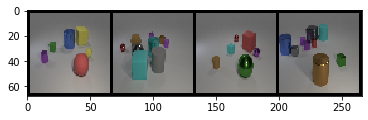

In [16]:
plt.imshow(to_pil_image(make_grid(inp).cpu()))

In [17]:
with torch.no_grad():
    emb_recon_loss_triplets, grad_norms, recon_losses, gen_debug = gen(inp, disc, iters=5)

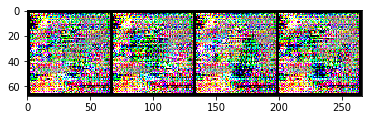

In [18]:
plt.imshow(to_pil_image(make_grid(emb_recon_loss_triplets[-1][1]).cpu()))

In [193]:
recon = emb_recon_loss_triplets[-1][1]
bsz = inp.size(0)
real_first = torch.rand(bsz, 1, 1, 1, device=inp.device) >= 0.5
adv_contrast_inp = torch.cat((inp * real_first + recon * (~real_first), inp * ~real_first + recon * (real_first)), 1)
contrast_pred = disc(adv_contrast_inp)

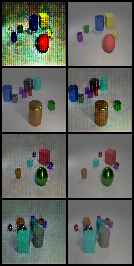

In [207]:
to_pil_image(make_grid(gen_debug[-1]['adv_contrast_inp'].view(-1, 3, 64, 64), nrow=2))

In [195]:
contrast_pred.sigmoid()

tensor([[0.0533, 0.3115, 0.6736],
        [0.2097, 0.3852, 0.6460],
        [0.2194, 0.4649, 0.5623],
        [0.1978, 0.5127, 0.4692]], grad_fn=<SigmoidBackward>)

In [177]:
real_first = gen_debug[-1]['real_first']
contrast_pred = gen_debug[-1]['contrast_pred']

fake_are_real_indices = ((real_first).long() + 1).flatten()
fake_are_real = torch.sigmoid(contrast_pred[torch.arange(bsz), fake_are_real_indices])

real_are_real_indices = ((~real_first).long() + 1).flatten()
real_are_real = torch.sigmoid(contrast_pred[torch.arange(bsz), real_are_real_indices])

are_same = contrast_pred[:, 0].sigmoid()

In [179]:
fake_are_real, real_are_real

(tensor([0.7098, 0.7327, 0.4191, 0.6071]),
 tensor([0.3698, 0.2832, 0.5861, 0.4081]))

In [173]:
gen_debug[0]

{'adv_contrast_inp': tensor([[[[0.4790, 0.4726, 0.4690,  ..., 0.4603, 0.4637, 0.4672],
           [0.4810, 0.4654, 0.4591,  ..., 0.4571, 0.4561, 0.4580],
           [0.4740, 0.4604, 0.4583,  ..., 0.4536, 0.4532, 0.4541],
           ...,
           [0.4995, 0.4841, 0.4836,  ..., 0.5429, 0.5300, 0.5290],
           [0.4941, 0.4899, 0.4945,  ..., 0.5432, 0.5295, 0.5288],
           [0.4956, 0.4896, 0.4903,  ..., 0.5332, 0.5297, 0.5205]],
 
          [[0.4761, 0.4688, 0.4710,  ..., 0.4501, 0.4618, 0.4674],
           [0.4753, 0.4602, 0.4587,  ..., 0.4422, 0.4495, 0.4482],
           [0.4716, 0.4591, 0.4613,  ..., 0.4386, 0.4455, 0.4470],
           ...,
           [0.5010, 0.4880, 0.4816,  ..., 0.5238, 0.5303, 0.5217],
           [0.4925, 0.4823, 0.4867,  ..., 0.5311, 0.5271, 0.5303],
           [0.4908, 0.4896, 0.4903,  ..., 0.5255, 0.5249, 0.5216]],
 
          [[0.4686, 0.4697, 0.4717,  ..., 0.4487, 0.4598, 0.4595],
           [0.4728, 0.4640, 0.4632,  ..., 0.4406, 0.4586, 0.4501],
    

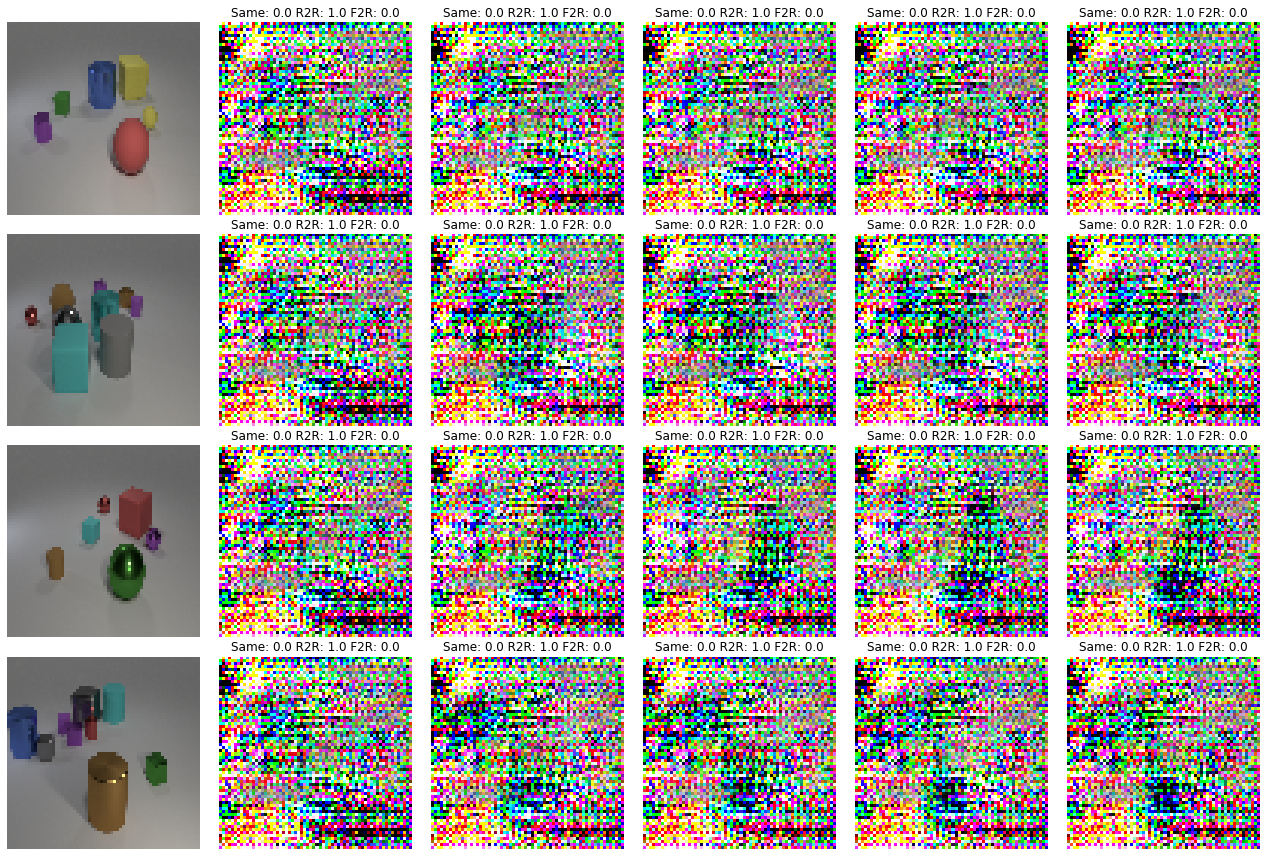

In [21]:
recon_fig, recon_axes = plt.subplots(ncols=1 + len(emb_recon_loss_triplets), nrows=bsz, figsize=((len(emb_recon_loss_triplets) + 1) * 3, 3 * bsz))
for col in range(len(emb_recon_loss_triplets)):
    real_first_col = gen_debug[col]['real_first']
    contrast_pred_col = gen_debug[col]['contrast_pred']
    
    fake_are_real_indices = ((real_first_col).long() + 1).flatten()
    fake_are_real = torch.sigmoid(contrast_pred_col[torch.arange(bsz), fake_are_real_indices])

    real_are_real_indices = ((~real_first_col).long() + 1).flatten()
    real_are_real = torch.sigmoid(contrast_pred_col[torch.arange(bsz), real_are_real_indices])

    are_same = contrast_pred_col[:, 0].sigmoid()
    
    for row in range(bsz):
        ax = recon_axes[row, col + 1]
        ax.imshow(to_pil_image(emb_recon_loss_triplets[col][1][row].cpu()))
        ax.axis('off')
        ax.set_title(f'Same: {round(are_same[row].item(), 1)} R2R: {round(real_are_real[row].item(), 1)} F2R: {round(fake_are_real[row].item(), 1)}')
        
for ax_i, inp_i in zip(recon_axes, inp):
    ax = ax_i[0]
    ax.imshow(to_pil_image(inp_i.cpu()))
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.05)

In [28]:
total_disc_loss, disc_debug = discriminator_update_step(inp, disc, gen)

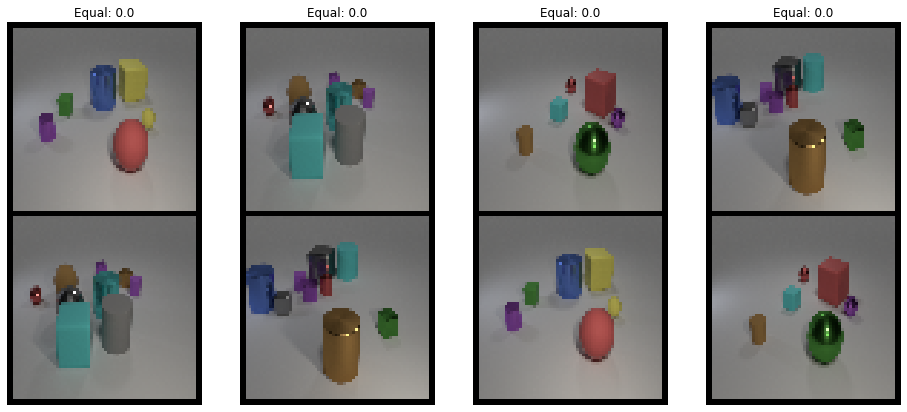

In [29]:
different_fig, different_axes = plt.subplots(nrows=1, ncols=bsz, figsize=(bsz * 4, 8))
for ax, pair, equal_prob in zip(different_axes, disc_debug['different_inp'].cpu(), torch.sigmoid(disc_debug['different_pred'].cpu()[:, 0])):
    img_pair_i = to_pil_image(make_grid(pair.view(2, 3, 64, 64), nrow=1))
    ax.imshow(img_pair_i)
    ax.set_title(f'Equal: {round(equal_prob.item(), 1)}')
    ax.axis('off')

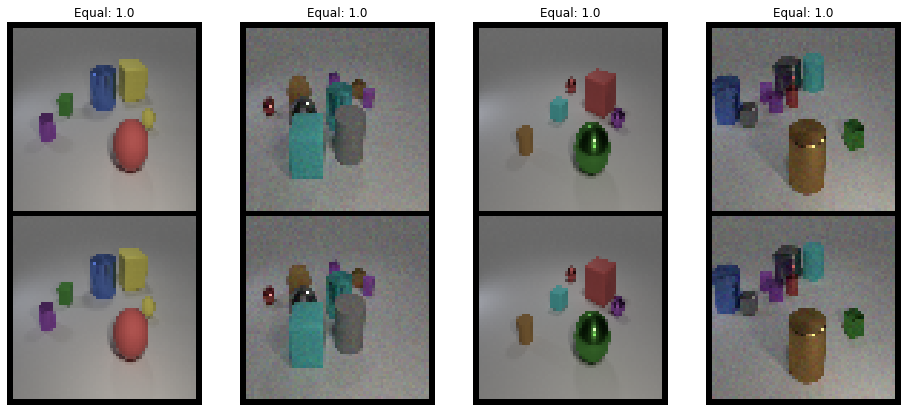

In [31]:
same_fig, same_axes = plt.subplots(nrows=1, ncols=bsz, figsize=(bsz * 4, 8))
for ax, pair, equal_prob in zip(same_axes, disc_debug['same_inp'].cpu(), torch.sigmoid(disc_debug['same_pred'].cpu()[:, 0])):
    img_pair_i = to_pil_image(make_grid(pair.view(2, 3, 64, 64), nrow=1))
    ax.imshow(img_pair_i)
    ax.set_title(f'Equal: {round(equal_prob.item(), 1)}')
    ax.axis('off')